## Install packages and dependencies


In [0]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (45.0.0)


## Import packages

In [0]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import os
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from collections import deque
from IPython.display import HTML
from IPython import display as ipythondisplay
from PIL import Image
from itertools import count
from collections import namedtuple
import PIL

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import Compose, ToPILImage, Resize, ToTensor, Grayscale

print(torch.__version__)

1.3.1


In [0]:
# cuda availability
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

## Import virtual display

In [6]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1237'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1237'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

## Utils

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos(indexes=None):
  mp4list = sorted(glob.glob('video/*.mp4'), key=os.path.getsize)
  if len(mp4list) == 0: print("There are no videos")
  for idx in (indexes or range(len(mp4list))):
    show_video(mp4list[idx])

def show_video(mp4):
  video = io.open(mp4, 'r+b').read()
  encoded = base64.b64encode(video)
  video_name = mp4[mp4.rfind('/'):mp4.rfind('.')]
  print("Video {} - Episode {} - Size {}".format(video_name, video_name[mp4.rfind('o'):], len(video)))
  ipythondisplay.display(HTML(data='''<video alt="test" autoplay loop controls style="height: 400px;">
                              <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                              </video>'''.format(encoded.decode('ascii'))))

def execute_simple_env(env):
  observation = env.reset()
  done = False
  while not done:
    # render environment
    env.render()
    # choose action
    action = env.action_space.sample()
    # take action
    observation, reward, done, info = env.step(action)
  env.close()
  return env

# CartPole v1

### Environment

In [0]:
class CartPoleEnv:
  def __init__(self):
    self.env = Monitor(gym.make("CartPole-v1"), './video', force=True, video_callable=self.video_callable)

    self.action_space = self.env.action_space
    self.observation_space = self.env.observation_space
    self.n_steps = 0
    self.max_steps_per_episode = 0

    print("[CartPole-v1]")
    print("Registry: max_episode_steps=500 - reward_threshold=475.0")
    print("Spaces: action: {} - observation: {}", self.action_space, self.observation_space)

    self.reset()
    self.resize = T.Compose([T.ToPILImage(), T.Resize(40, interpolation=Image.CUBIC), T.ToTensor()])

  def video_callable(self, episode_id):
    if self.n_steps > self.max_steps_per_episode:
      self.max_steps_per_episode = self.n_steps
      return True
    return False

  def reset(self):
    obs = self.env.reset()
    self.n_steps = 0
    return obs

  def perform_action(self, action):
    obs, reward, done, info = self.env.step(action)
    reward = torch.tensor([reward], device=device)
    self.n_steps += 1
    return obs, reward, done, info

  def close(self):
    self.env.close()

  def render(self, mode=None):
    observation = self.env.render() if mode is None else self.env.render(mode=mode)
    return observation

  def get_observation_size(self):
    _, _, height, weight = self.get_observation().shape
    return (height, weight)

  def get_cart_location(self, img_width):
    world_width = self.env.x_threshold * 2
    scale = img_width / world_width
    return int(self.env.state[0] * scale + img_width / 2.0)

  def get_observation(self):

    # compute sizes
    observation = self.render(mode='rgb_array').transpose((2, 0, 1))
    _, height, width = observation.shape
    observation = observation[:, int(height * 0.4) : int(height * 0.8)]
    img_width = int(width * 0.6)

    # get cart location
    cart_location = self.get_cart_location(width)
    if cart_location < img_width // 2:
        slice_range = slice(img_width)
    elif cart_location > (width - img_width // 2):
        slice_range = slice(-img_width, None)
    else:
        slice_range = slice(cart_location - img_width // 2, cart_location + img_width // 2)
    
    # center img on the car
    observation = observation[:, :, slice_range]

    # rescale
    observation = torch.from_numpy(np.ascontiguousarray(observation, dtype=np.float32) / 255)

    # resize
    return self.resize(observation).unsqueeze(0).to(device)

### Convolutional Neural Network

In [0]:
class CNN(nn.Module):
  def __init__(self, input_size, outputs, kernel_size=5, stride=2):

    super(CNN, self).__init__()
    print("[CNN] H: {} - W: {} - O: {}".format(input_size[0], input_size[1], outputs))

    self.kernel_size = kernel_size
    self.stride = stride

    self.conv1 = nn.Conv2d(3, 16, kernel_size=self.kernel_size, stride=self.stride)
    conv1_size = self.conv2d_output_size(input_size)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=self.kernel_size, stride=self.stride)
    conv2_size = self.conv2d_output_size(conv1_size)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 32, kernel_size=self.kernel_size, stride=self.stride)
    conv3_size = self.conv2d_output_size(conv2_size)
    self.bn3 = nn.BatchNorm2d(32)

    linear_input_size = conv3_size[1] * conv3_size[0] * 32
    self.top = nn.Linear(linear_input_size, outputs)

  def conv2d_output_size(self, input_size):
    size = lambda n, k, s: (n - (k - 1) - 1 ) // s + 1 
    return (size(input_size[0], self.kernel_size, self.stride), size(input_size[1], self.kernel_size, self.stride))

  def forward(self, x):
    relu1 = F.relu(self.bn1(self.conv1(x)))
    relu2 = F.relu(self.bn2(self.conv2(relu1)))
    relu3 = F.relu(self.bn3(self.conv3(relu2)))
    return self.top(relu3.view(relu3.size(0), -1))

### Agent

In [0]:
Transition = namedtuple('Transition', ('prev_observation', 'action', 'observation', 'reward'))

class Memory(object):
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def remember(self, fact):
      self.memory.append(fact)

    def remind(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [0]:
class CNNAgent:
  def __init__(self, environment, batch_size, epsilon=0.9, epsilon_min=0.05, epsilon_decay=200, gamma=0.999, learning_rate=0.001, kernel_size=5, stride=2):

    # environment
    self.env = environment

    # memory
    self.memory = Memory(20000)

    # parameters
    self.batch_size = batch_size
    self.epsilon = epsilon
    self.epsilon_min = epsilon_min
    self.epsilon_decay = epsilon_decay
    self.gamma = gamma

    # variables
    self.n_steps = 0
    self.observation_size = self.env.get_observation_size()
    self.action_space_size = self.env.action_space.n
    self.last_observation_motive = None

    # models
    self.policy_model = CNN(self.observation_size, self.action_space_size)
    self.policy_model.cuda()

    # optimizer
    self.optimizer = optim.RMSprop(self.policy_model.parameters(), learning_rate)

    print("[CNNAgent] Observation_size: {} - Action_space_size: {}".format(self.observation_size, self.action_space_size))

  def act(self, action):
    return self.env.perform_action(action)

  def observe(self):
    prev_observation_motive = self.last_observation_motive
    self.last_observation_motive = self.env.get_observation()
    if prev_observation_motive is None:
      return self.last_observation_motive * 0
    return self.last_observation_motive - prev_observation_motive

  def decide(self, observation):
    eps_threshold = self.epsilon_min + (self.epsilon - self.epsilon_min) * math.exp(-1. * self.n_steps / self.epsilon_decay)
    self.n_steps += 1
    if random.random() > eps_threshold:
      with torch.no_grad():
        return self.policy_model(observation).max(1)[1].view(1, 1)
    else:
      return torch.tensor([[random.randrange(self.action_space_size)]], device=device, dtype=torch.long)

  def memorize(self, *args):
    fact = Transition(*args)
    self.memory.remember(fact)

  def learn(self):
    if len(self.memory) < self.batch_size: return

    # remind sample of transitions
    transitions = self.memory.remind(self.batch_size)
    batch = Transition(*zip(*transitions))

    # create tensors
    prev_observations = torch.cat(batch.prev_observation)
    actions = torch.cat(batch.action)
    rewards = torch.cat(batch.reward)
    observations_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.observation)), device=device, dtype=torch.bool)
    observations = torch.cat([s for s in batch.observation if s is not None])
    
    # hypothetical actions
    prev_observations_action_values = self.policy_model(prev_observations).gather(1, actions)

    # expected actions
    observations_values = torch.zeros(self.batch_size, device=device)
    observations_values[observations_mask] = self.policy_model(observations).max(1)[0].detach()
    expected_observations_action_values = (observations_values * self.gamma) + rewards

    # compute loss
    loss = F.smooth_l1_loss(prev_observations_action_values, expected_observations_action_values.unsqueeze(1))

    # optimize
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

### Test

In [12]:
# settings
n_episodes = 100
batch_size = 128
epsilon = 0.9
epsilon_min = 0.01
epsilon_decay = 225
gamma = 0.999
learning_rate = 0.0005
kernel_size = 5
stride = 2

# create environment
cp_env = CartPoleEnv()

# create agent
agent = CNNAgent(cp_env, batch_size, epsilon=epsilon, epsilon_min = epsilon_min, epsilon_decay=epsilon_decay,
                 gamma=gamma, learning_rate=learning_rate, kernel_size=kernel_size, stride=stride)

[CartPole-v1]
Registry: max_episode_steps=500 - reward_threshold=475.0
Spaces: action: {} - observation: {} Discrete(2) Box(4,)
[CNN] H: 40 - W: 90 - O: 2
[CNNAgent] Observation_size: (40, 90) - Action_space_size: 2


In [13]:
# game status
last_scores, finish_game = deque(maxlen=5), False
last_scores.extend([0]*5)

# episodes
for i in range(n_episodes):
  cp_env.reset()

  # compute initial state
  prev_observation = agent.observe()
  observation = prev_observation

  # steps
  for t in count():

    # choose the action
    action = agent.decide(prev_observation)

    # perform the action
    _, reward, done, info = agent.act(action.item())

    # update observations motive
    observation = None if done else agent.observe()

    # memorize transition
    agent.memorize(prev_observation, action, observation, reward)

    # update observations
    prev_observation = observation

    # deduce optimizations
    agent.learn()

    # finish if done
    if done:
      print("Episode {} with {} steps {}".format(i + 1, t + 1, " -> WON" if t+1 >= 500 else ""))
      last_scores.append(t+1>=450)
      finish_game = np.array(last_scores).all()
      break
      
  if finish_game:
    print("FINISH - Last five scores over 450. Higher 10%")
    break # finish when last five scores over 450. Higher 10%

cp_env.close()

Episode 1 with 14 steps 
Episode 2 with 21 steps 
Episode 3 with 25 steps 
Episode 4 with 12 steps 
Episode 5 with 23 steps 
Episode 6 with 15 steps 
Episode 7 with 11 steps 
Episode 8 with 16 steps 
Episode 9 with 14 steps 
Episode 10 with 15 steps 
Episode 11 with 18 steps 
Episode 12 with 12 steps 
Episode 13 with 36 steps 
Episode 14 with 27 steps 
Episode 15 with 13 steps 
Episode 16 with 11 steps 
Episode 17 with 35 steps 
Episode 18 with 15 steps 
Episode 19 with 11 steps 
Episode 20 with 32 steps 
Episode 21 with 30 steps 
Episode 22 with 14 steps 
Episode 23 with 9 steps 
Episode 24 with 20 steps 
Episode 25 with 18 steps 
Episode 26 with 26 steps 
Episode 27 with 15 steps 
Episode 28 with 16 steps 
Episode 29 with 37 steps 
Episode 30 with 48 steps 
Episode 31 with 21 steps 
Episode 32 with 16 steps 
Episode 33 with 22 steps 
Episode 34 with 46 steps 
Episode 35 with 33 steps 
Episode 36 with 37 steps 
Episode 37 with 27 steps 
Episode 38 with 41 steps 
Episode 39 with 16 ste

# Results

### Plot stats

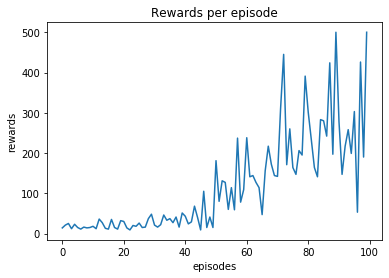

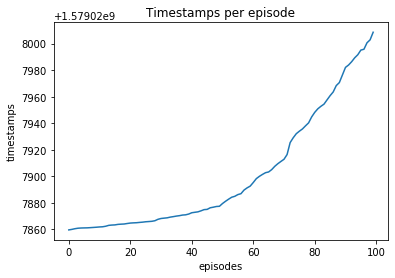

In [14]:
import json

json_files = glob.glob('video/*.json')
json_file = list(filter(lambda f: 'stats' in f, json_files))[0] 

with open(json_file) as f:
  data = json.load(f)

  plt.plot(data['episode_rewards'])
  plt.title('Rewards per episode')
  plt.ylabel('rewards')
  plt.xlabel('episodes')
  plt.show()

  plt.plot(data['timestamps'])
  plt.title('Timestamps per episode')
  plt.ylabel('timestamps')
  plt.xlabel('episodes')
  plt.show()

### Videos

In [15]:
# show shortest and longest video
show_videos([-1]) # indexes ordered by size of video

Video /openaigym.video.0.54654.video000073 - Episode 73 - Size 41179
